In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
from torch.utils.data import DataLoader, TensorDataset


In [5]:
E_modulus = 200  
C1, C2 = 0, 0
noise_level = 0  
def generate_nonlinear_elastic_data(epsilon_values, E, C1, C2, noise_level):
    sigma = E * epsilon_values + C1 * epsilon_values ** 2 + C2 * epsilon_values ** 3
    noise = noise_level * np.random.randn(*epsilon_values.shape)
    return sigma + noise
epsilon_train = np.linspace(0, 0.3, 100).reshape(-1, 1).astype(np.float32)
sigma_train = generate_nonlinear_elastic_data(epsilon_train, E_modulus, C1, C2, noise_level).astype(np.float32)
epsilon_train_tensor = torch.tensor(epsilon_train)
sigma_train_tensor = torch.tensor(sigma_train)
std_train_stress = torch.std(sigma_train_tensor).item()
# Normalize the data using min-max normalization
x_data = epsilon_train_tensor.numpy()
y_data = sigma_train_tensor.numpy()
x_min, x_max = x_data.min(), x_data.max()
y_min, y_max = y_data.min(), y_data.max()
x_data = (x_data - x_min) / (x_max - x_min)
y_data = (y_data - y_min) / (y_max - y_min)
x_tensor = torch.tensor(x_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.float32)
# Create DataLoader for shuffling
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [6]:
# Define SoftplusSquared Activation function
class SoftplusSquared(nn.Module):
    def __init__(self, beta=1):
        super(SoftplusSquared, self).__init__()
        self.beta = nn.Parameter(torch.tensor(float(beta)))  # Make beta a trainable parameter
    def forward(self, x):
        return (1 / (2 * self.beta ** 4)) * (torch.log10(1+torch.exp(self.beta ** 2 * x))) ** 2

class ConstrainedLinear(nn.Module):
    def __init__(self, in_features, out_features, alpha=1):
        super(ConstrainedLinear, self).__init__()
        self.raw_weights = nn.Parameter(torch.randn(out_features, in_features))  # Trainable weights
        self.alpha = nn.Parameter(torch.tensor(float(alpha)))  # Trainable parameter
    def forward(self, x):
        # Constrain weights to be positive using numerically stable softplus
        positive_weights = (1 / (self.alpha ** 2)) * torch.log10(1+torch.exp(self.alpha ** 2 * self.raw_weights))
        return F.linear(x, positive_weights)

# Define neural network model
class ICNN(nn.Module):
    def __init__(self, input_dim):
        super(ICNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 20)
        self.constrained_layer1 = ConstrainedLinear(20, 10)
        self.constrained_layer2 = ConstrainedLinear(10, 10)
        self.constrained_layer3 = ConstrainedLinear(10, 1)
        self.A = nn.Parameter(torch.randn(input_dim, input_dim))  # Trainable A
        self.shortcut_layer2 = nn.Linear(input_dim, 10, bias=False)
        self.shortcut_layer3 = nn.Linear(input_dim, 10, bias=False)
        self.activation = SoftplusSquared()
    def forward(self, x):
        x0 = x  # Original input (batch_size, input_dim)
        shortcut2 = self.shortcut_layer2(x)  
        shortcut3 = self.shortcut_layer3(x)  
        x = self.activation(self.layer1(x))  
        x = self.activation(self.constrained_layer1(x) + shortcut2) 
        x = self.activation(self.constrained_layer2(x) + shortcut3)
       #  Quadratic term computation: f(x0) = x0^T A^T A x0
        quadratic_term = torch.matmul(x0, self.A.T)  # Compute x0^T * A^T  # Compute x^T * A^T
        quadratic_term = torch.matmul(quadratic_term, self.A)  # Compute x0^T * A^T * A  # Compute x^T * A^T * A
        quadratic_output = torch.sum(quadratic_term * x0, dim=1, keepdim=True)  # Compute final quadratic term involving x0  # Compute x^T * A^T * A * x0
        x = self.constrained_layer3(x) + quadratic_output
        return x



In [7]:

def custom_loss_energy_to_stress_with_fixed_std(model, inputs, targets, std_train_stress):
    inputs.requires_grad = True
    energy_outputs = model(inputs)  # Predicted energy (W)
    # Compute stress as the derivative of energy with respect to strain
    stress_outputs = torch.autograd.grad(
        outputs=energy_outputs, 
        inputs=inputs,
        grad_outputs=torch.ones_like(energy_outputs),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]  
    # Compute the stress at reference input (epsilon = 0)
    reference_input = torch.zeros_like(inputs, requires_grad=True)  # Set requires_grad=True
    reference_energy_output = model(reference_input)
    reference_stress = torch.autograd.grad(
        outputs=reference_energy_output, 
        inputs=reference_input,
        grad_outputs=torch.ones_like(reference_energy_output),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    normalized_error = (stress_outputs - reference_stress - targets) / std_train_stress
    loss = torch.sum(normalized_error ** 2)  # Mean of squared normalized error
    return loss


In [8]:

# Instantiate the model, define loss and optimizer
input_dim=1
model = ICNN(input_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with gradient clipping
epochs = 5000
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        # loss = criterion(outputs, batch_y)
        loss = custom_loss_energy_to_stress_with_fixed_std(model, batch_x, batch_y, std_train_stress)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')




Epoch [100/5000], Loss: 0.0004
Epoch [200/5000], Loss: 0.0002
Epoch [300/5000], Loss: 0.0001
Epoch [400/5000], Loss: 0.0000
Epoch [500/5000], Loss: 0.0000
Epoch [600/5000], Loss: 0.0000
Epoch [700/5000], Loss: 0.0000
Epoch [800/5000], Loss: 0.0000
Epoch [900/5000], Loss: 0.0000
Epoch [1000/5000], Loss: 0.0000
Epoch [1100/5000], Loss: 0.0000
Epoch [1200/5000], Loss: 0.0000
Epoch [1300/5000], Loss: 0.0000
Epoch [1400/5000], Loss: 0.0000
Epoch [1500/5000], Loss: 0.0000
Epoch [1600/5000], Loss: 0.0000
Epoch [1700/5000], Loss: 0.0000
Epoch [1800/5000], Loss: 0.0000
Epoch [1900/5000], Loss: 0.0000
Epoch [2000/5000], Loss: 0.0000
Epoch [2100/5000], Loss: 0.0000
Epoch [2200/5000], Loss: 0.0000
Epoch [2300/5000], Loss: 0.0000
Epoch [2400/5000], Loss: 0.0000
Epoch [2500/5000], Loss: 0.0000
Epoch [2600/5000], Loss: 0.0000
Epoch [2700/5000], Loss: 0.0000
Epoch [2800/5000], Loss: 0.0000
Epoch [2900/5000], Loss: 0.0000
Epoch [3000/5000], Loss: 0.0000
Epoch [3100/5000], Loss: 0.0000
Epoch [3200/5000]

In [9]:
# Evaluate the model
model.eval()
y_pred = model(x_tensor).detach().numpy()
x_data = x_data * (x_max - x_min) + x_min
y_data = y_data * (y_max - y_min) + y_min
y_pred = y_pred * (y_max - y_min) + y_min
epsilon_out_of_range = np.linspace(0.3, 0.5, 50).reshape(-1, 1).astype(np.float32)
epsilon_out_of_range_normalized = (epsilon_out_of_range - x_min) / (x_max - x_min)
epsilon_out_of_range_tensor = torch.tensor(epsilon_out_of_range_normalized, dtype=torch.float32)
sigma_out_of_range_pred = model(epsilon_out_of_range_tensor).detach().numpy()
sigma_out_of_range_pred = sigma_out_of_range_pred * (y_max - y_min) + y_min
sigma_out_of_range_analytical = (
    E_modulus * epsilon_out_of_range
    + C1 * epsilon_out_of_range ** 2
    + C2 * epsilon_out_of_range ** 3
)

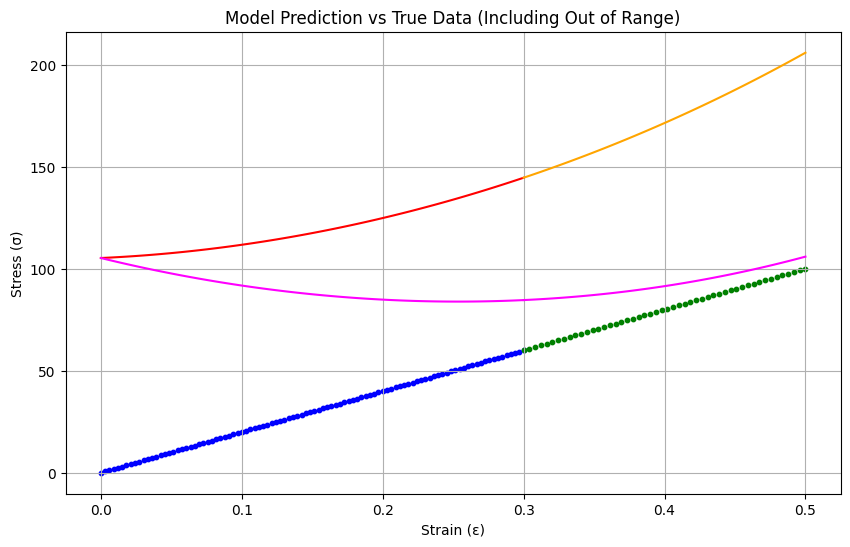

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='True Data (Training Range)', color='blue', s=10)
plt.plot(x_data, y_pred, label='Model Prediction (Training Range)', color='red')
plt.scatter(epsilon_out_of_range, sigma_out_of_range_analytical, label='True Data (Out of Range)', color='green', s=10)
plt.plot(epsilon_out_of_range, sigma_out_of_range_pred, label='Model Prediction (Out of Range)', color='orange')
plt.plot(x_data, y_pred-y_data, color='magenta')
plt.plot(epsilon_out_of_range, sigma_out_of_range_pred-sigma_out_of_range_analytical, color='magenta')
# plt.legend()
plt.xlabel('Strain (ε)')
plt.ylabel('Stress (σ)')
plt.title('Model Prediction vs True Data (Including Out of Range)')
plt.grid(True)
plt.show()